In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


In [2]:
import os  # Add this line at the beginning of your code

save_dir = '/kaggle/working/'  # Specify your directory path
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [3]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Paths to the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata CSV
labels = pd.read_csv(metadata_file)

# Convert diagnosis (dx) to integers (you can map specific diseases if needed)
label_mapping = {label: idx for idx, label in enumerate(labels['dx'].unique())}
labels['dx'] = labels['dx'].map(label_mapping)

# Set image size for the model
IMG_SIZE = 28  # Resize images to 28x28

# Function to load and preprocess images
def load_images_and_labels(labels, image_dir_1, image_dir_2, img_size=28):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize it
        img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
        label_list.append(row['dx'])  # Add the label (dx)

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = np.array(label_list)  # Labels: [0, 1, 2, ..., 6] for classification
    return X, y

# Load the images and labels
X, y = load_images_and_labels(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Step 1: Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the 80% training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Check the shape of the dataset
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Compute class weights to handle class imbalance
def compute_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(labels), y=labels
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weight_dict

class_weights = compute_class_weights(y_train)

# Data Augmentation for the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for the validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creating data pipeline for training and validation
train_dataset = train_datagen.flow(X_train, y_train_one_hot, batch_size=16)
val_dataset = val_datagen.flow(X_val, y_val_one_hot, batch_size=16)

# Efficient data pipeline: cache, batch, and prefetch (for training and validation datasets)
def create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

    # Efficient data pipeline: cache, batch, and prefetch
    train_data = (train_data
                  .cache()
                  .shuffle(buffer_size=1000)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
    
    val_data = (val_data
                .cache()
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

    test_data = (test_data
                 .cache()
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

    return train_data, val_data, test_data

# Set batch size for training
batch_size = 32

# Create the dataset pipeline for efficient data loading
train_data, val_data, test_data = create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size)


Training set shape: (5608, 28, 28, 3)
Validation set shape: (2404, 28, 28, 3)
Test set shape: (2003, 28, 28, 3)


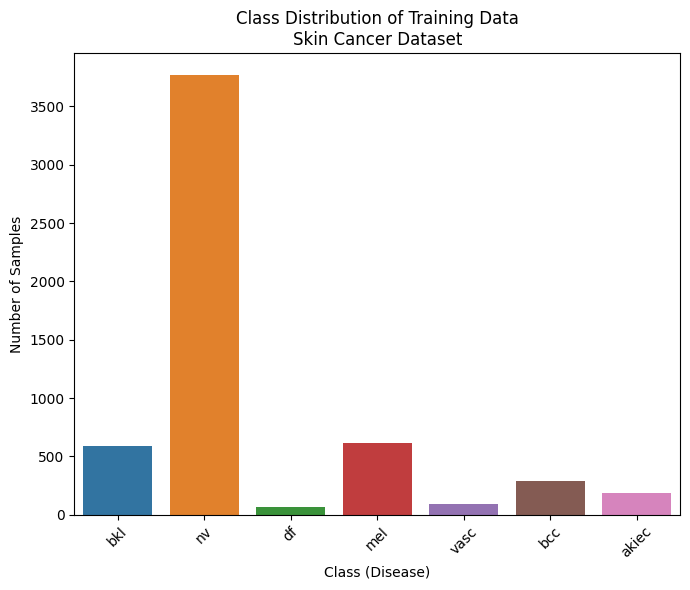

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add disease names for better interpretation
disease_labels = {v: k for k, v in label_mapping.items()}

# Update the plot function to show disease names on the x-axis
def plot_class_distribution(y_original, title, disease_labels):
    y_original_series = pd.Series(y_original)
    
    original_class_dist = y_original_series.value_counts().sort_index()
    
    # Plot the class distribution
    plt.figure(figsize=(7, 6))
    sns.barplot(x=original_class_dist.index, y=original_class_dist.values)
    plt.title(f'Class Distribution of Training Data\n{title}')
    plt.xlabel('Class (Disease)')
    plt.ylabel('Number of Samples')
    plt.xticks(ticks=original_class_dist.index, labels=[disease_labels.get(i, i) for i in original_class_dist.index], rotation=45)
    plt.tight_layout()
    plt.show()

# Call the updated function to plot the class distribution of the original training data
plot_class_distribution(y_train, 'Skin Cancer Dataset', disease_labels)


Random Image from Training Data:


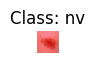

In [6]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to display a random image from the dataset
def display_random_image(X, y, labels, img_size=28):
    # Pick a random index
    random_index = random.randint(0, len(X) - 1)
    
    # Get the image and its corresponding label
    random_img = X[random_index]
    random_label = y[random_index]
    
    # Convert image array back to displayable format (no resizing)
    random_img_display = image.array_to_img(random_img)
    
    # Get the actual image dimensions
    img_height, img_width, _ = random_img.shape
    
    # Set the figure size based on the actual image size (in inches)
    # Convert pixels to inches (assuming 100 dpi by default)
    figsize = (img_width / 100, img_height / 100)
    
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(random_img_display)
    plt.title(f"Class: {labels[random_label]}")
    plt.axis('off')  # Hide axes for better clarity
    plt.show()

# Display a random image from the original dataset
def visualize_random_image(X_train, y_train, labels_reverse, img_size=28):
    print("Random Image from Training Data:")
    display_random_image(X_train, y_train, labels_reverse, img_size)

# Convert label back to its original class name using the 'label_mapping'
labels_reverse = {v: k for k, v in label_mapping.items()}  # Reverse the label mapping

# Visualize a random image from the original training data at actual size
visualize_random_image(X_train, y_train, labels_reverse, img_size=28)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 128  # Latent dimension (size of the compressed representation)

# Encoder (Updated with reduced filters, depthwise separable convolutions, and batch normalization)
encoder = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 3)),
    layers.SeparableConv2D(16, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (28, 28) -> (14, 14, 16)
    layers.BatchNormalization(),
    
    layers.SeparableConv2D(32, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (14, 14) -> (7, 7, 32)
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation (128)
])

# Decoder (Updated to output 28x28 with 'same' padding, using depthwise separable convolutions)
decoder = tf.keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(7 * 7 * 32, activation="relu"),  # Upscale to match the desired dimensions
    layers.Reshape((7, 7, 32)),  # Shape after first dense layer
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'),  # (14, 14, 32)
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'),  # (28, 28, 16)
    layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='sigmoid'),  # (28, 28, 3)
])

# Full autoencoder model
autoencoder_input = layers.Input(shape=(28, 28, 3))  # Changed input shape to (28, 28, 3)
latent_representation = encoder(autoencoder_input)
reconstructed_image = decoder(latent_representation)

autoencoder = models.Model(inputs=autoencoder_input, outputs=reconstructed_image)

# Compile the autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Print model summary to check the architecture
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │         201,803 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 3)           │         216,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,510 (1.60 MB)

 Trainable params: 418,350 (1.60 MB)

 Non-trainable params: 160 (640.00 B)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_discriminator(input_shape=(28, 28, 3), num_classes=7):
    model = models.Sequential()

    # First convolutional layer with 16 filters and 'same' padding
    model.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    
    # Second convolutional layer with 32 filters and 'valid' padding (matches provided output)
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))  # (28, 28) -> (26, 26)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (26, 26) -> (13, 13)
    model.add(layers.BatchNormalization())
    
    # Third convolutional layer with 32 filters and 'same' padding
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))  # (13, 13) -> (13, 13)

    # Fourth convolutional layer with 64 filters and 'valid' padding
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))  # (13, 13) -> (11, 11)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (11, 11) -> (6, 6)
    model.add(layers.BatchNormalization())
    
    # Flatten the feature maps
    model.add(layers.Flatten())  # (6, 6, 64) -> 2304

    # Dense layer (fully connected) with 64 units
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    
    # Fully connected (dense) layer with 32 units
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with Softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output 7 classes
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the discriminator model
num_classes = 7  # Number of classes in the dataset (e.g., 7 for HAM10000 dataset)
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=num_classes)

# Display the model summary
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,055 (539.28 KB)

 Trainable params: 137,831 (538.40 KB)

 Non-trainable params: 224 (896.00 B)

In [9]:

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tqdm import tqdm

# Assuming you have an autoencoder model that is already trained
# Use the decoder part of the autoencoder as the generator
generator = autoencoder.layers[-2]  # Decoder of the autoencoder
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=7)

# Define the GAN model
def create_gan(generator, discriminator, latent_dim=128):
    # Freeze the discriminator during the generator training
    discriminator.trainable = False

    # Input layer for random noise (latent vector of size 128)
    gan_input = layers.Input(shape=(latent_dim,))
    
    # Use the generator (autoencoder's decoder) to generate images
    x = generator(gan_input)  # Generator generates fake images
    gan_output = discriminator(x)  # Discriminator evaluates the fake image

    # Build the GAN model
    gan = models.Model(gan_input, gan_output)
    
    # Compile the GAN with categorical cross-entropy loss for multi-class classification
    gan.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    return gan

# Loss functions for the autoencoder and discriminator
loss_fn_auto = tf.keras.losses.MeanSquaredError()  # For the autoencoder (reconstruction loss)
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # For discriminator (classification loss)

# Optimizers for autoencoder and discriminator
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Metrics to store losses and accuracies for tracking
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop for GAN
for epoch in range(300):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):
        with tf.GradientTape(persistent=True) as tape:
            # Pass batch through the encoder and decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Pass batch through the discriminator (real vs fake image)
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients to autoencoder
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        # Apply gradients to discriminator
        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())

        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_data:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 176/176 [00:50<00:00,  3.48it/s]


Epoch 0, Autoencoder Loss: 0.03408076614141464, Discriminator Loss: 1.2600516080856323, Discriminator Accuracy: 0.6551846861839294
Validation - Autoencoder Loss: 0.021855220198631287, Discriminator Loss: 1.1366287469863892, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 1, Autoencoder Loss: 0.020266495645046234, Discriminator Loss: 1.1191681623458862, Discriminator Accuracy: 0.6711647510528564
Validation - Autoencoder Loss: 0.019566433504223824, Discriminator Loss: 1.095311164855957, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 2, Autoencoder Loss: 0.018502656370401382, Discriminator Loss: 1.0883616209030151, Discriminator Accuracy: 0.6722301244735718
Validation - Autoencoder Loss: 0.01743837632238865, Discriminator Loss: 1.092724084854126, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 3, Autoencoder Loss: 0.014402530156075954, Discriminator Loss: 1.059211015701294, Discriminator Accuracy: 0.6732954382896423
Validation - Autoencoder Loss: 0.01139141246676445, Discriminator Loss: 1.0233768224716187, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 4, Autoencoder Loss: 0.010021411813795567, Discriminator Loss: 0.9980170726776123, Discriminator Accuracy: 0.6715198755264282
Validation - Autoencoder Loss: 0.009063510224223137, Discriminator Loss: 0.9920628070831299, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 5, Autoencoder Loss: 0.008082830347120762, Discriminator Loss: 0.9732948541641235, Discriminator Accuracy: 0.6711647510528564
Validation - Autoencoder Loss: 0.007482412736862898, Discriminator Loss: 0.9545722007751465, Discriminator Accuracy: 0.6644737124443054


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 6, Autoencoder Loss: 0.006692719645798206, Discriminator Loss: 0.9429319500923157, Discriminator Accuracy: 0.6729403138160706
Validation - Autoencoder Loss: 0.006401063408702612, Discriminator Loss: 0.9462577700614929, Discriminator Accuracy: 0.6644737124443054


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 7, Autoencoder Loss: 0.005810650996863842, Discriminator Loss: 0.925032377243042, Discriminator Accuracy: 0.6720525622367859
Validation - Autoencoder Loss: 0.005661848001182079, Discriminator Loss: 0.9147432446479797, Discriminator Accuracy: 0.6673519611358643


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 8, Autoencoder Loss: 0.005262553226202726, Discriminator Loss: 0.9033340215682983, Discriminator Accuracy: 0.6759588122367859
Validation - Autoencoder Loss: 0.005249697249382734, Discriminator Loss: 0.8981544971466064, Discriminator Accuracy: 0.6685855388641357


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 9, Autoencoder Loss: 0.0049480292946100235, Discriminator Loss: 0.8847141861915588, Discriminator Accuracy: 0.6821733117103577
Validation - Autoencoder Loss: 0.004986269865185022, Discriminator Loss: 0.8848233222961426, Discriminator Accuracy: 0.6722862124443054


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 10, Autoencoder Loss: 0.004739570431411266, Discriminator Loss: 0.8705694079399109, Discriminator Accuracy: 0.6830610632896423
Validation - Autoencoder Loss: 0.004796034190803766, Discriminator Loss: 0.8778550028800964, Discriminator Accuracy: 0.6759868264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 11, Autoencoder Loss: 0.0045679304748773575, Discriminator Loss: 0.8617562651634216, Discriminator Accuracy: 0.6889204382896423
Validation - Autoencoder Loss: 0.004655763506889343, Discriminator Loss: 0.8802679777145386, Discriminator Accuracy: 0.6759868264198303


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 12, Autoencoder Loss: 0.004433868918567896, Discriminator Loss: 0.8528181314468384, Discriminator Accuracy: 0.6899858117103577
Validation - Autoencoder Loss: 0.004546609241515398, Discriminator Loss: 0.8661927580833435, Discriminator Accuracy: 0.6825658082962036


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 13, Autoencoder Loss: 0.004307762254029512, Discriminator Loss: 0.8410559296607971, Discriminator Accuracy: 0.6942471861839294
Validation - Autoencoder Loss: 0.004414822906255722, Discriminator Loss: 0.8859094381332397, Discriminator Accuracy: 0.6825658082962036


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 14, Autoencoder Loss: 0.004192442633211613, Discriminator Loss: 0.832472562789917, Discriminator Accuracy: 0.6947798132896423
Validation - Autoencoder Loss: 0.004293663892894983, Discriminator Loss: 0.8456164002418518, Discriminator Accuracy: 0.6862664222717285


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 15, Autoencoder Loss: 0.004082770552486181, Discriminator Loss: 0.8305705785751343, Discriminator Accuracy: 0.6921164989471436
Validation - Autoencoder Loss: 0.004203522112220526, Discriminator Loss: 0.849777102470398, Discriminator Accuracy: 0.6850329041481018


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 16, Autoencoder Loss: 0.003976208157837391, Discriminator Loss: 0.8232881426811218, Discriminator Accuracy: 0.7013494372367859
Validation - Autoencoder Loss: 0.004076978657394648, Discriminator Loss: 0.8334447741508484, Discriminator Accuracy: 0.6912006735801697


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 17, Autoencoder Loss: 0.0038716427516192198, Discriminator Loss: 0.8152493834495544, Discriminator Accuracy: 0.69921875
Validation - Autoencoder Loss: 0.003982095047831535, Discriminator Loss: 0.8549196124076843, Discriminator Accuracy: 0.6875


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 18, Autoencoder Loss: 0.0037750473711639643, Discriminator Loss: 0.8112800121307373, Discriminator Accuracy: 0.7001065611839294
Validation - Autoencoder Loss: 0.003896537469699979, Discriminator Loss: 0.840660035610199, Discriminator Accuracy: 0.6879112124443054


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 19, Autoencoder Loss: 0.003692065365612507, Discriminator Loss: 0.8062828183174133, Discriminator Accuracy: 0.6990411877632141
Validation - Autoencoder Loss: 0.003825630759820342, Discriminator Loss: 0.8359950184822083, Discriminator Accuracy: 0.6879112124443054


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 20, Autoencoder Loss: 0.003619475057348609, Discriminator Loss: 0.8016647100448608, Discriminator Accuracy: 0.7034801244735718
Validation - Autoencoder Loss: 0.003742729313671589, Discriminator Loss: 0.841594398021698, Discriminator Accuracy: 0.6924341917037964


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 21, Autoencoder Loss: 0.003554977709427476, Discriminator Loss: 0.7956825494766235, Discriminator Accuracy: 0.7066761255264282
Validation - Autoencoder Loss: 0.0036851633340120316, Discriminator Loss: 0.8295701742172241, Discriminator Accuracy: 0.6990131735801697


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 22, Autoencoder Loss: 0.0034890531096607447, Discriminator Loss: 0.8011161684989929, Discriminator Accuracy: 0.7043678760528564
Validation - Autoencoder Loss: 0.003623566823080182, Discriminator Loss: 0.819793164730072, Discriminator Accuracy: 0.6957237124443054


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 23, Autoencoder Loss: 0.0034474311396479607, Discriminator Loss: 0.7850643396377563, Discriminator Accuracy: 0.7086292505264282
Validation - Autoencoder Loss: 0.0035862475633621216, Discriminator Loss: 0.8203667402267456, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 24, Autoencoder Loss: 0.003400463843718171, Discriminator Loss: 0.786604106426239, Discriminator Accuracy: 0.7075639367103577
Validation - Autoencoder Loss: 0.003539772005751729, Discriminator Loss: 0.8179610967636108, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 25, Autoencoder Loss: 0.003360204165801406, Discriminator Loss: 0.7816500067710876, Discriminator Accuracy: 0.7088068127632141
Validation - Autoencoder Loss: 0.0034942184574902058, Discriminator Loss: 0.8256330490112305, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 26, Autoencoder Loss: 0.003317425958812237, Discriminator Loss: 0.781223475933075, Discriminator Accuracy: 0.7098721861839294
Validation - Autoencoder Loss: 0.003462158842012286, Discriminator Loss: 0.8166612982749939, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 27, Autoencoder Loss: 0.0032793045975267887, Discriminator Loss: 0.7747663259506226, Discriminator Accuracy: 0.7105823755264282
Validation - Autoencoder Loss: 0.003482345724478364, Discriminator Loss: 0.8073999881744385, Discriminator Accuracy: 0.6973684430122375


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 28, Autoencoder Loss: 0.0032621906138956547, Discriminator Loss: 0.7718921899795532, Discriminator Accuracy: 0.7098721861839294
Validation - Autoencoder Loss: 0.0034121430944651365, Discriminator Loss: 0.8410830497741699, Discriminator Accuracy: 0.6854440569877625


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 29, Autoencoder Loss: 0.0032184573356062174, Discriminator Loss: 0.7693609595298767, Discriminator Accuracy: 0.7111150622367859
Validation - Autoencoder Loss: 0.0033712454605847597, Discriminator Loss: 0.8097589612007141, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 30, Autoencoder Loss: 0.003191776806488633, Discriminator Loss: 0.7600229382514954, Discriminator Accuracy: 0.7125355005264282
Validation - Autoencoder Loss: 0.003346984041854739, Discriminator Loss: 0.8068267703056335, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 31, Autoencoder Loss: 0.0031650459859520197, Discriminator Loss: 0.7569103240966797, Discriminator Accuracy: 0.7169744372367859
Validation - Autoencoder Loss: 0.0033316698390990496, Discriminator Loss: 0.8025621175765991, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 32, Autoencoder Loss: 0.0031289150938391685, Discriminator Loss: 0.7541391849517822, Discriminator Accuracy: 0.7114701867103577
Validation - Autoencoder Loss: 0.0032846243120729923, Discriminator Loss: 0.8125318288803101, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 33, Autoencoder Loss: 0.0031049870885908604, Discriminator Loss: 0.7536243200302124, Discriminator Accuracy: 0.7151988744735718
Validation - Autoencoder Loss: 0.0032760011963546276, Discriminator Loss: 0.8380749225616455, Discriminator Accuracy: 0.6932565569877625


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 34, Autoencoder Loss: 0.0030787810683250427, Discriminator Loss: 0.7495653033256531, Discriminator Accuracy: 0.7150213122367859
Validation - Autoencoder Loss: 0.003243896644562483, Discriminator Loss: 0.8094537854194641, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 35, Autoencoder Loss: 0.0030529911164194345, Discriminator Loss: 0.7427390813827515, Discriminator Accuracy: 0.7182173132896423
Validation - Autoencoder Loss: 0.003206608584150672, Discriminator Loss: 0.8104915618896484, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 36, Autoencoder Loss: 0.003022986464202404, Discriminator Loss: 0.7403165698051453, Discriminator Accuracy: 0.7214133739471436
Validation - Autoencoder Loss: 0.0031884489580988884, Discriminator Loss: 0.8055621981620789, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 37, Autoencoder Loss: 0.0030079835560172796, Discriminator Loss: 0.7388288378715515, Discriminator Accuracy: 0.7182173132896423
Validation - Autoencoder Loss: 0.003169574774801731, Discriminator Loss: 0.7921509146690369, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 38, Autoencoder Loss: 0.002973229391500354, Discriminator Loss: 0.7269862294197083, Discriminator Accuracy: 0.7201704382896423
Validation - Autoencoder Loss: 0.0031339116394519806, Discriminator Loss: 0.799391508102417, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 39, Autoencoder Loss: 0.002950226655229926, Discriminator Loss: 0.7272372841835022, Discriminator Accuracy: 0.72265625
Validation - Autoencoder Loss: 0.003123114351183176, Discriminator Loss: 0.7953017354011536, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 40, Autoencoder Loss: 0.0029281878378242254, Discriminator Loss: 0.7248702645301819, Discriminator Accuracy: 0.7228338122367859
Validation - Autoencoder Loss: 0.0030946610495448112, Discriminator Loss: 0.8038704991340637, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 41, Autoencoder Loss: 0.002901425352320075, Discriminator Loss: 0.7246873378753662, Discriminator Accuracy: 0.7228338122367859
Validation - Autoencoder Loss: 0.003061974421143532, Discriminator Loss: 0.7960865497589111, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 42, Autoencoder Loss: 0.0028804540634155273, Discriminator Loss: 0.7160618305206299, Discriminator Accuracy: 0.7217684388160706
Validation - Autoencoder Loss: 0.0030400282703340054, Discriminator Loss: 0.7989258170127869, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 43, Autoencoder Loss: 0.002855346305295825, Discriminator Loss: 0.7177957892417908, Discriminator Accuracy: 0.7253196239471436
Validation - Autoencoder Loss: 0.0030171473044902086, Discriminator Loss: 0.784963846206665, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 44, Autoencoder Loss: 0.0028455951251089573, Discriminator Loss: 0.7084742188453674, Discriminator Accuracy: 0.7258522510528564
Validation - Autoencoder Loss: 0.003024066798388958, Discriminator Loss: 0.8030797839164734, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 45, Autoencoder Loss: 0.0028155420441180468, Discriminator Loss: 0.7011839151382446, Discriminator Accuracy: 0.7270951867103577
Validation - Autoencoder Loss: 0.0029931599274277687, Discriminator Loss: 0.8065313696861267, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 46, Autoencoder Loss: 0.00279135606251657, Discriminator Loss: 0.7006124258041382, Discriminator Accuracy: 0.7302911877632141
Validation - Autoencoder Loss: 0.002953865798190236, Discriminator Loss: 0.8178947567939758, Discriminator Accuracy: 0.6994243264198303


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 47, Autoencoder Loss: 0.0027755654882639647, Discriminator Loss: 0.7004536390304565, Discriminator Accuracy: 0.7325994372367859
Validation - Autoencoder Loss: 0.002928975271061063, Discriminator Loss: 0.8263731598854065, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 48, Autoencoder Loss: 0.0027561383321881294, Discriminator Loss: 0.6941478252410889, Discriminator Accuracy: 0.7290483117103577
Validation - Autoencoder Loss: 0.002917130012065172, Discriminator Loss: 0.8075111508369446, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 49, Autoencoder Loss: 0.0027364371344447136, Discriminator Loss: 0.6883520483970642, Discriminator Accuracy: 0.7347301244735718
Validation - Autoencoder Loss: 0.002885345369577408, Discriminator Loss: 0.7913129329681396, Discriminator Accuracy: 0.6990131735801697


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 50, Autoencoder Loss: 0.0027155971620231867, Discriminator Loss: 0.6826947331428528, Discriminator Accuracy: 0.7318891882896423
Validation - Autoencoder Loss: 0.0028771187644451857, Discriminator Loss: 0.7936608195304871, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 51, Autoencoder Loss: 0.002701678080484271, Discriminator Loss: 0.6786996126174927, Discriminator Accuracy: 0.7347301244735718
Validation - Autoencoder Loss: 0.0028760500717908144, Discriminator Loss: 0.8051092028617859, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 52, Autoencoder Loss: 0.002682015299797058, Discriminator Loss: 0.6799479126930237, Discriminator Accuracy: 0.7379261255264282
Validation - Autoencoder Loss: 0.00284650013782084, Discriminator Loss: 0.7894437909126282, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 53, Autoencoder Loss: 0.002665397245436907, Discriminator Loss: 0.670393168926239, Discriminator Accuracy: 0.7386363744735718
Validation - Autoencoder Loss: 0.0028320779092609882, Discriminator Loss: 0.7867937684059143, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 54, Autoencoder Loss: 0.0026542115956544876, Discriminator Loss: 0.6627851724624634, Discriminator Accuracy: 0.7411221861839294
Validation - Autoencoder Loss: 0.002827191725373268, Discriminator Loss: 0.795113205909729, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 55, Autoencoder Loss: 0.0026373742148280144, Discriminator Loss: 0.6651556491851807, Discriminator Accuracy: 0.7434303760528564
Validation - Autoencoder Loss: 0.0028046180959790945, Discriminator Loss: 0.7929120659828186, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 56, Autoencoder Loss: 0.0026223051827400923, Discriminator Loss: 0.6644850373268127, Discriminator Accuracy: 0.7412996888160706
Validation - Autoencoder Loss: 0.0028130810242146254, Discriminator Loss: 0.7923263907432556, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 57, Autoencoder Loss: 0.0026197615079581738, Discriminator Loss: 0.6604146361351013, Discriminator Accuracy: 0.7384588122367859
Validation - Autoencoder Loss: 0.0027876899112015963, Discriminator Loss: 0.7842360138893127, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 58, Autoencoder Loss: 0.002595176687464118, Discriminator Loss: 0.6539186239242554, Discriminator Accuracy: 0.7416548132896423
Validation - Autoencoder Loss: 0.0027645130176097155, Discriminator Loss: 0.7922590970993042, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 59, Autoencoder Loss: 0.002583207795396447, Discriminator Loss: 0.6477931141853333, Discriminator Accuracy: 0.7462713122367859
Validation - Autoencoder Loss: 0.0027573241386562586, Discriminator Loss: 0.8209848999977112, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 60, Autoencoder Loss: 0.0025745502207428217, Discriminator Loss: 0.6421034336090088, Discriminator Accuracy: 0.7503551244735718
Validation - Autoencoder Loss: 0.0027344808913767338, Discriminator Loss: 0.8259628415107727, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 61, Autoencoder Loss: 0.002560775261372328, Discriminator Loss: 0.6383690237998962, Discriminator Accuracy: 0.7489346861839294
Validation - Autoencoder Loss: 0.00271929451264441, Discriminator Loss: 0.7936273217201233, Discriminator Accuracy: 0.7109375


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 62, Autoencoder Loss: 0.0025446193758398294, Discriminator Loss: 0.6365743279457092, Discriminator Accuracy: 0.7484019994735718
Validation - Autoencoder Loss: 0.0027115035336464643, Discriminator Loss: 0.8038588166236877, Discriminator Accuracy: 0.7129934430122375


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 63, Autoencoder Loss: 0.0025445667561143637, Discriminator Loss: 0.6335905194282532, Discriminator Accuracy: 0.7510653138160706
Validation - Autoencoder Loss: 0.0027094478718936443, Discriminator Loss: 0.8024017214775085, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 64, Autoencoder Loss: 0.002530142432078719, Discriminator Loss: 0.6292018294334412, Discriminator Accuracy: 0.7540838122367859
Validation - Autoencoder Loss: 0.0026843128725886345, Discriminator Loss: 0.7879897952079773, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 65, Autoencoder Loss: 0.0025215456262230873, Discriminator Loss: 0.6280273199081421, Discriminator Accuracy: 0.7540838122367859
Validation - Autoencoder Loss: 0.002677052514627576, Discriminator Loss: 0.8117551207542419, Discriminator Accuracy: 0.7142269611358643


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 66, Autoencoder Loss: 0.002508223755285144, Discriminator Loss: 0.6235648989677429, Discriminator Accuracy: 0.7594105005264282
Validation - Autoencoder Loss: 0.002671158639714122, Discriminator Loss: 0.808999240398407, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 67, Autoencoder Loss: 0.0024931316729635, Discriminator Loss: 0.6160455346107483, Discriminator Accuracy: 0.7537286877632141
Validation - Autoencoder Loss: 0.002654029056429863, Discriminator Loss: 0.7898554801940918, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 68, Autoencoder Loss: 0.0024843052960932255, Discriminator Loss: 0.6126415729522705, Discriminator Accuracy: 0.7578125
Validation - Autoencoder Loss: 0.0026527910958975554, Discriminator Loss: 0.7948001623153687, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 69, Autoencoder Loss: 0.0024777597282081842, Discriminator Loss: 0.6089306473731995, Discriminator Accuracy: 0.7551491260528564
Validation - Autoencoder Loss: 0.0026409251149743795, Discriminator Loss: 0.8070642352104187, Discriminator Accuracy: 0.7092927694320679


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 70, Autoencoder Loss: 0.0024742858950048685, Discriminator Loss: 0.6031936407089233, Discriminator Accuracy: 0.7594105005264282
Validation - Autoencoder Loss: 0.002640754682943225, Discriminator Loss: 0.7892740964889526, Discriminator Accuracy: 0.7138158082962036


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 71, Autoencoder Loss: 0.0024578478187322617, Discriminator Loss: 0.6014246344566345, Discriminator Accuracy: 0.7620738744735718
Validation - Autoencoder Loss: 0.00262552872300148, Discriminator Loss: 0.7949933409690857, Discriminator Accuracy: 0.7142269611358643


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 72, Autoencoder Loss: 0.002450281288474798, Discriminator Loss: 0.5971430540084839, Discriminator Accuracy: 0.7631391882896423
Validation - Autoencoder Loss: 0.002620561746880412, Discriminator Loss: 0.8030692338943481, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 73, Autoencoder Loss: 0.0024391161277890205, Discriminator Loss: 0.5943435430526733, Discriminator Accuracy: 0.7666903138160706
Validation - Autoencoder Loss: 0.0025985415559262037, Discriminator Loss: 0.8055039048194885, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 74, Autoencoder Loss: 0.00243705534376204, Discriminator Loss: 0.589104950428009, Discriminator Accuracy: 0.7654474377632141
Validation - Autoencoder Loss: 0.002604787005111575, Discriminator Loss: 0.8177451491355896, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 75, Autoencoder Loss: 0.0024242799263447523, Discriminator Loss: 0.5867086052894592, Discriminator Accuracy: 0.7661576867103577
Validation - Autoencoder Loss: 0.0025866960640996695, Discriminator Loss: 0.8098329901695251, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 76, Autoencoder Loss: 0.002418664749711752, Discriminator Loss: 0.5824540257453918, Discriminator Accuracy: 0.765625
Validation - Autoencoder Loss: 0.002587222261354327, Discriminator Loss: 0.7973877787590027, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 77, Autoencoder Loss: 0.002405245089903474, Discriminator Loss: 0.5789763927459717, Discriminator Accuracy: 0.7693536877632141
Validation - Autoencoder Loss: 0.0025729022454470396, Discriminator Loss: 0.8146283626556396, Discriminator Accuracy: 0.7080591917037964


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 78, Autoencoder Loss: 0.002396197058260441, Discriminator Loss: 0.5750041604042053, Discriminator Accuracy: 0.765625
Validation - Autoencoder Loss: 0.002565920352935791, Discriminator Loss: 0.8175340294837952, Discriminator Accuracy: 0.7006579041481018


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 79, Autoencoder Loss: 0.0023855462204664946, Discriminator Loss: 0.5689170956611633, Discriminator Accuracy: 0.7741477489471436
Validation - Autoencoder Loss: 0.002555449493229389, Discriminator Loss: 0.8319088220596313, Discriminator Accuracy: 0.7051809430122375


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 80, Autoencoder Loss: 0.0023815687745809555, Discriminator Loss: 0.5675325393676758, Discriminator Accuracy: 0.7729048132896423
Validation - Autoencoder Loss: 0.0025538012851029634, Discriminator Loss: 0.8200770020484924, Discriminator Accuracy: 0.7121710777282715


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 81, Autoencoder Loss: 0.0023763456847518682, Discriminator Loss: 0.5622206330299377, Discriminator Accuracy: 0.7762784361839294
Validation - Autoencoder Loss: 0.0025389723014086485, Discriminator Loss: 0.8118417859077454, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 82, Autoencoder Loss: 0.002368583343923092, Discriminator Loss: 0.5536884069442749, Discriminator Accuracy: 0.7768110632896423
Validation - Autoencoder Loss: 0.0025315722450613976, Discriminator Loss: 0.8564216494560242, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 83, Autoencoder Loss: 0.0023587308824062347, Discriminator Loss: 0.5549232959747314, Discriminator Accuracy: 0.7737926244735718
Validation - Autoencoder Loss: 0.002521603601053357, Discriminator Loss: 0.835227906703949, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 84, Autoencoder Loss: 0.0023516358342021704, Discriminator Loss: 0.5475119948387146, Discriminator Accuracy: 0.7761008739471436
Validation - Autoencoder Loss: 0.0025317261461168528, Discriminator Loss: 0.868674099445343, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 85, Autoencoder Loss: 0.00234298431314528, Discriminator Loss: 0.5548809766769409, Discriminator Accuracy: 0.7771661877632141
Validation - Autoencoder Loss: 0.002512829378247261, Discriminator Loss: 0.8276132345199585, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 86, Autoencoder Loss: 0.0023360727354884148, Discriminator Loss: 0.5406850576400757, Discriminator Accuracy: 0.7830255627632141
Validation - Autoencoder Loss: 0.002509745769202709, Discriminator Loss: 0.8597407937049866, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 87, Autoencoder Loss: 0.0023283185437321663, Discriminator Loss: 0.5361177325248718, Discriminator Accuracy: 0.7823153138160706
Validation - Autoencoder Loss: 0.0024971207603812218, Discriminator Loss: 0.8398650288581848, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 88, Autoencoder Loss: 0.0023207643534988165, Discriminator Loss: 0.5307791233062744, Discriminator Accuracy: 0.7805397510528564
Validation - Autoencoder Loss: 0.0024892494548112154, Discriminator Loss: 0.8643688559532166, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 89, Autoencoder Loss: 0.0023142294958233833, Discriminator Loss: 0.5292124152183533, Discriminator Accuracy: 0.7887073755264282
Validation - Autoencoder Loss: 0.0024779606610536575, Discriminator Loss: 0.842728853225708, Discriminator Accuracy: 0.703125


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 90, Autoencoder Loss: 0.002305705565959215, Discriminator Loss: 0.5205948352813721, Discriminator Accuracy: 0.7922585010528564
Validation - Autoencoder Loss: 0.0024759627413004637, Discriminator Loss: 0.8358826041221619, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 91, Autoencoder Loss: 0.0023014883045107126, Discriminator Loss: 0.5229108333587646, Discriminator Accuracy: 0.7885298132896423
Validation - Autoencoder Loss: 0.002475630259141326, Discriminator Loss: 0.8445462584495544, Discriminator Accuracy: 0.6977795958518982


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 92, Autoencoder Loss: 0.002291216515004635, Discriminator Loss: 0.5155434012413025, Discriminator Accuracy: 0.7917258739471436
Validation - Autoencoder Loss: 0.002457309514284134, Discriminator Loss: 0.8436245322227478, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 93, Autoencoder Loss: 0.002285290276631713, Discriminator Loss: 0.5080723166465759, Discriminator Accuracy: 0.7933238744735718
Validation - Autoencoder Loss: 0.0024505178444087505, Discriminator Loss: 0.8597798347473145, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 94, Autoencoder Loss: 0.0022775831166654825, Discriminator Loss: 0.5063169002532959, Discriminator Accuracy: 0.7972301244735718
Validation - Autoencoder Loss: 0.0024413559585809708, Discriminator Loss: 0.8417856097221375, Discriminator Accuracy: 0.6977795958518982


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 95, Autoencoder Loss: 0.002270843368023634, Discriminator Loss: 0.5076059103012085, Discriminator Accuracy: 0.7945667505264282
Validation - Autoencoder Loss: 0.002437993185594678, Discriminator Loss: 0.8611617088317871, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 96, Autoencoder Loss: 0.0022693274077028036, Discriminator Loss: 0.4942549765110016, Discriminator Accuracy: 0.8020241260528564
Validation - Autoencoder Loss: 0.0024342655669897795, Discriminator Loss: 0.893356442451477, Discriminator Accuracy: 0.6916118264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 97, Autoencoder Loss: 0.00226246053352952, Discriminator Loss: 0.5007115006446838, Discriminator Accuracy: 0.7952769994735718
Validation - Autoencoder Loss: 0.002424827544018626, Discriminator Loss: 0.8736968040466309, Discriminator Accuracy: 0.6986019611358643


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 98, Autoencoder Loss: 0.0022509677801281214, Discriminator Loss: 0.4866909682750702, Discriminator Accuracy: 0.8052201867103577
Validation - Autoencoder Loss: 0.0024215795565396547, Discriminator Loss: 0.900038480758667, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 99, Autoencoder Loss: 0.0022556097246706486, Discriminator Loss: 0.48403817415237427, Discriminator Accuracy: 0.8025568127632141
Validation - Autoencoder Loss: 0.0024175180587917566, Discriminator Loss: 0.8829044699668884, Discriminator Accuracy: 0.6977795958518982


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 100, Autoencoder Loss: 0.0022383867762982845, Discriminator Loss: 0.48734989762306213, Discriminator Accuracy: 0.8045099377632141
Validation - Autoencoder Loss: 0.00240875082090497, Discriminator Loss: 0.896903395652771, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 101, Autoencoder Loss: 0.002231252146884799, Discriminator Loss: 0.4778255224227905, Discriminator Accuracy: 0.8048650622367859
Validation - Autoencoder Loss: 0.002403611084446311, Discriminator Loss: 0.8945073485374451, Discriminator Accuracy: 0.6920230388641357


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 102, Autoencoder Loss: 0.0022308146581053734, Discriminator Loss: 0.4776807129383087, Discriminator Accuracy: 0.8068181872367859
Validation - Autoencoder Loss: 0.002401299774646759, Discriminator Loss: 0.9045153260231018, Discriminator Accuracy: 0.6854440569877625


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 103, Autoencoder Loss: 0.002227203221991658, Discriminator Loss: 0.4722876250743866, Discriminator Accuracy: 0.8073508739471436
Validation - Autoencoder Loss: 0.0023937318474054337, Discriminator Loss: 0.935605525970459, Discriminator Accuracy: 0.6924341917037964


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 104, Autoencoder Loss: 0.0022161395754665136, Discriminator Loss: 0.4635672867298126, Discriminator Accuracy: 0.8156960010528564
Validation - Autoencoder Loss: 0.002382177161052823, Discriminator Loss: 0.9215720295906067, Discriminator Accuracy: 0.6957237124443054


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 105, Autoencoder Loss: 0.002208069432526827, Discriminator Loss: 0.4602365493774414, Discriminator Accuracy: 0.8155184388160706
Validation - Autoencoder Loss: 0.002367316046729684, Discriminator Loss: 0.9041112661361694, Discriminator Accuracy: 0.6805098652839661


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 106, Autoencoder Loss: 0.0022010935936123133, Discriminator Loss: 0.46044713258743286, Discriminator Accuracy: 0.810546875
Validation - Autoencoder Loss: 0.0023631309159100056, Discriminator Loss: 0.9086770415306091, Discriminator Accuracy: 0.6895559430122375


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 107, Autoencoder Loss: 0.0021963545586913824, Discriminator Loss: 0.44866111874580383, Discriminator Accuracy: 0.8194246888160706
Validation - Autoencoder Loss: 0.0023818043991923332, Discriminator Loss: 0.9199264645576477, Discriminator Accuracy: 0.6912006735801697


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 108, Autoencoder Loss: 0.002190637867897749, Discriminator Loss: 0.4541040360927582, Discriminator Accuracy: 0.8162286877632141
Validation - Autoencoder Loss: 0.0023601881694048643, Discriminator Loss: 0.9208146333694458, Discriminator Accuracy: 0.6883223652839661


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 109, Autoencoder Loss: 0.002184317447245121, Discriminator Loss: 0.44614341855049133, Discriminator Accuracy: 0.8162286877632141
Validation - Autoencoder Loss: 0.0023544018622487783, Discriminator Loss: 0.9474547505378723, Discriminator Accuracy: 0.6883223652839661


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 110, Autoencoder Loss: 0.0021791125182062387, Discriminator Loss: 0.4443496763706207, Discriminator Accuracy: 0.8204900622367859
Validation - Autoencoder Loss: 0.002340794773772359, Discriminator Loss: 0.9424883127212524, Discriminator Accuracy: 0.6932565569877625


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 111, Autoencoder Loss: 0.0021724191028624773, Discriminator Loss: 0.4382460415363312, Discriminator Accuracy: 0.8194246888160706
Validation - Autoencoder Loss: 0.002330761170014739, Discriminator Loss: 0.947439968585968, Discriminator Accuracy: 0.6842105388641357


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 112, Autoencoder Loss: 0.0021679045166820288, Discriminator Loss: 0.42627274990081787, Discriminator Accuracy: 0.8236860632896423
Validation - Autoencoder Loss: 0.002337720012292266, Discriminator Loss: 0.9501347541809082, Discriminator Accuracy: 0.6903783082962036


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 113, Autoencoder Loss: 0.0021558934822678566, Discriminator Loss: 0.42385900020599365, Discriminator Accuracy: 0.8240411877632141
Validation - Autoencoder Loss: 0.0023208647035062313, Discriminator Loss: 0.949081301689148, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 114, Autoencoder Loss: 0.002146683866158128, Discriminator Loss: 0.4179064929485321, Discriminator Accuracy: 0.8236860632896423
Validation - Autoencoder Loss: 0.002313175005838275, Discriminator Loss: 0.953876793384552, Discriminator Accuracy: 0.6912006735801697


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 115, Autoencoder Loss: 0.002137857722118497, Discriminator Loss: 0.4175448715686798, Discriminator Accuracy: 0.8275923132896423
Validation - Autoencoder Loss: 0.0023082762490957975, Discriminator Loss: 0.9585270285606384, Discriminator Accuracy: 0.6833881735801697


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 116, Autoencoder Loss: 0.002133555943146348, Discriminator Loss: 0.410997211933136, Discriminator Accuracy: 0.8336292505264282
Validation - Autoencoder Loss: 0.00229925150051713, Discriminator Loss: 0.9684010744094849, Discriminator Accuracy: 0.6936677694320679


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 117, Autoencoder Loss: 0.0021280362270772457, Discriminator Loss: 0.4136563241481781, Discriminator Accuracy: 0.8355823755264282
Validation - Autoencoder Loss: 0.0022893035784363747, Discriminator Loss: 0.964332103729248, Discriminator Accuracy: 0.6998355388641357


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 118, Autoencoder Loss: 0.0021109459921717644, Discriminator Loss: 0.4038923382759094, Discriminator Accuracy: 0.8350496888160706
Validation - Autoencoder Loss: 0.002272849204018712, Discriminator Loss: 0.9912595152854919, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 119, Autoencoder Loss: 0.002103332197293639, Discriminator Loss: 0.3959442377090454, Discriminator Accuracy: 0.8409090638160706
Validation - Autoencoder Loss: 0.0022644370328634977, Discriminator Loss: 1.0013278722763062, Discriminator Accuracy: 0.7068256735801697


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 120, Autoencoder Loss: 0.002085538813844323, Discriminator Loss: 0.39190244674682617, Discriminator Accuracy: 0.8421519994735718
Validation - Autoencoder Loss: 0.0022571783047169447, Discriminator Loss: 0.9874113202095032, Discriminator Accuracy: 0.6788651347160339


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 121, Autoencoder Loss: 0.0020668008364737034, Discriminator Loss: 0.3889738917350769, Discriminator Accuracy: 0.8412641882896423
Validation - Autoencoder Loss: 0.0022221251856535673, Discriminator Loss: 1.020795464515686, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 122, Autoencoder Loss: 0.0020441666711121798, Discriminator Loss: 0.3897467851638794, Discriminator Accuracy: 0.8435724377632141
Validation - Autoencoder Loss: 0.0022144087124615908, Discriminator Loss: 0.995884358882904, Discriminator Accuracy: 0.6920230388641357


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 123, Autoencoder Loss: 0.0020110709592700005, Discriminator Loss: 0.387534499168396, Discriminator Accuracy: 0.8449928760528564
Validation - Autoencoder Loss: 0.0021791153121739626, Discriminator Loss: 1.0280404090881348, Discriminator Accuracy: 0.6907894611358643


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 124, Autoencoder Loss: 0.001978814136236906, Discriminator Loss: 0.36830615997314453, Discriminator Accuracy: 0.8531605005264282
Validation - Autoencoder Loss: 0.002138616517186165, Discriminator Loss: 1.0009260177612305, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 125, Autoencoder Loss: 0.001954127801582217, Discriminator Loss: 0.36966755986213684, Discriminator Accuracy: 0.8570667505264282
Validation - Autoencoder Loss: 0.0021145702339708805, Discriminator Loss: 1.0391734838485718, Discriminator Accuracy: 0.6698190569877625


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 126, Autoencoder Loss: 0.0019307048059999943, Discriminator Loss: 0.36345335841178894, Discriminator Accuracy: 0.8533380627632141
Validation - Autoencoder Loss: 0.002101496560499072, Discriminator Loss: 1.0334904193878174, Discriminator Accuracy: 0.6912006735801697


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 127, Autoencoder Loss: 0.0019174180924892426, Discriminator Loss: 0.3544102907180786, Discriminator Accuracy: 0.8579545617103577
Validation - Autoencoder Loss: 0.0020816077012568712, Discriminator Loss: 1.0357778072357178, Discriminator Accuracy: 0.6957237124443054


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 128, Autoencoder Loss: 0.001901528681628406, Discriminator Loss: 0.34324896335601807, Discriminator Accuracy: 0.8615056872367859
Validation - Autoencoder Loss: 0.002075950615108013, Discriminator Loss: 1.0629435777664185, Discriminator Accuracy: 0.6928454041481018


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 129, Autoencoder Loss: 0.0018887862097471952, Discriminator Loss: 0.3474830389022827, Discriminator Accuracy: 0.859375
Validation - Autoencoder Loss: 0.0020595428068190813, Discriminator Loss: 1.0572513341903687, Discriminator Accuracy: 0.6953125


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 130, Autoencoder Loss: 0.0018806162988767028, Discriminator Loss: 0.33664387464523315, Discriminator Accuracy: 0.8675426244735718
Validation - Autoencoder Loss: 0.002055743709206581, Discriminator Loss: 1.0288307666778564, Discriminator Accuracy: 0.6981908082962036


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 131, Autoencoder Loss: 0.0018741197418421507, Discriminator Loss: 0.3223400413990021, Discriminator Accuracy: 0.8753551244735718
Validation - Autoencoder Loss: 0.0020441319793462753, Discriminator Loss: 1.1020047664642334, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 132, Autoencoder Loss: 0.0018680156208574772, Discriminator Loss: 0.3270375430583954, Discriminator Accuracy: 0.8728693127632141
Validation - Autoencoder Loss: 0.002032934222370386, Discriminator Loss: 1.0605541467666626, Discriminator Accuracy: 0.6866776347160339


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 133, Autoencoder Loss: 0.0018659286433830857, Discriminator Loss: 0.32023879885673523, Discriminator Accuracy: 0.8728693127632141
Validation - Autoencoder Loss: 0.0020334154833108187, Discriminator Loss: 1.0743831396102905, Discriminator Accuracy: 0.6961348652839661


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 134, Autoencoder Loss: 0.0018503476167097688, Discriminator Loss: 0.31432244181632996, Discriminator Accuracy: 0.8785511255264282
Validation - Autoencoder Loss: 0.002026904374361038, Discriminator Loss: 1.1104987859725952, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 135, Autoencoder Loss: 0.0018458090489730239, Discriminator Loss: 0.3086279630661011, Discriminator Accuracy: 0.8805042505264282
Validation - Autoencoder Loss: 0.0020215094555169344, Discriminator Loss: 1.1233692169189453, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 136, Autoencoder Loss: 0.0018375070067122579, Discriminator Loss: 0.3093600571155548, Discriminator Accuracy: 0.8829900622367859
Validation - Autoencoder Loss: 0.0020106784068048, Discriminator Loss: 1.1260737180709839, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 137, Autoencoder Loss: 0.0018314571352675557, Discriminator Loss: 0.30512046813964844, Discriminator Accuracy: 0.8796164989471436
Validation - Autoencoder Loss: 0.0020004231482744217, Discriminator Loss: 1.1498115062713623, Discriminator Accuracy: 0.6698190569877625


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 138, Autoencoder Loss: 0.0018299465300515294, Discriminator Loss: 0.30287522077560425, Discriminator Accuracy: 0.8792613744735718
Validation - Autoencoder Loss: 0.0020012990571558475, Discriminator Loss: 1.1461132764816284, Discriminator Accuracy: 0.6899670958518982


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 139, Autoencoder Loss: 0.0018241368234157562, Discriminator Loss: 0.28470009565353394, Discriminator Accuracy: 0.8877840638160706
Validation - Autoencoder Loss: 0.001990006072446704, Discriminator Loss: 1.1197210550308228, Discriminator Accuracy: 0.6821545958518982


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 140, Autoencoder Loss: 0.0018215116579085588, Discriminator Loss: 0.29568660259246826, Discriminator Accuracy: 0.8842329382896423
Validation - Autoencoder Loss: 0.001997128129005432, Discriminator Loss: 1.1358017921447754, Discriminator Accuracy: 0.6788651347160339


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 141, Autoencoder Loss: 0.001814187620766461, Discriminator Loss: 0.2847825288772583, Discriminator Accuracy: 0.8899147510528564
Validation - Autoencoder Loss: 0.0019848670344799757, Discriminator Loss: 1.1705398559570312, Discriminator Accuracy: 0.6981908082962036


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 142, Autoencoder Loss: 0.0018080652225762606, Discriminator Loss: 0.27430951595306396, Discriminator Accuracy: 0.8941761255264282
Validation - Autoencoder Loss: 0.0019767249468714, Discriminator Loss: 1.1697038412094116, Discriminator Accuracy: 0.6726973652839661


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 143, Autoencoder Loss: 0.0018003322184085846, Discriminator Loss: 0.2829536199569702, Discriminator Accuracy: 0.888671875
Validation - Autoencoder Loss: 0.001969520701095462, Discriminator Loss: 1.2013294696807861, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 144, Autoencoder Loss: 0.0017991397762671113, Discriminator Loss: 0.27190107107162476, Discriminator Accuracy: 0.8920454382896423
Validation - Autoencoder Loss: 0.001966775394976139, Discriminator Loss: 1.1679078340530396, Discriminator Accuracy: 0.6759868264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 145, Autoencoder Loss: 0.0017937321681529284, Discriminator Loss: 0.2735060453414917, Discriminator Accuracy: 0.8980823755264282
Validation - Autoencoder Loss: 0.0019734844099730253, Discriminator Loss: 1.1879417896270752, Discriminator Accuracy: 0.6854440569877625


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 146, Autoencoder Loss: 0.0017862390959635377, Discriminator Loss: 0.2565065026283264, Discriminator Accuracy: 0.8993253111839294
Validation - Autoencoder Loss: 0.0019624901469796896, Discriminator Loss: 1.1684843301773071, Discriminator Accuracy: 0.6907894611358643


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 147, Autoencoder Loss: 0.001781090977601707, Discriminator Loss: 0.25475552678108215, Discriminator Accuracy: 0.9018110632896423
Validation - Autoencoder Loss: 0.0019498910987749696, Discriminator Loss: 1.196047067642212, Discriminator Accuracy: 0.6875


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 148, Autoencoder Loss: 0.0017784708179533482, Discriminator Loss: 0.25643694400787354, Discriminator Accuracy: 0.9032315611839294
Validation - Autoencoder Loss: 0.0019531564321368933, Discriminator Loss: 1.2495323419570923, Discriminator Accuracy: 0.6990131735801697


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 149, Autoencoder Loss: 0.0017820261418819427, Discriminator Loss: 0.2485913336277008, Discriminator Accuracy: 0.9048295617103577
Validation - Autoencoder Loss: 0.001943261013366282, Discriminator Loss: 1.2318588495254517, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 150, Autoencoder Loss: 0.0017699721502140164, Discriminator Loss: 0.2378941923379898, Discriminator Accuracy: 0.9110440611839294
Validation - Autoencoder Loss: 0.001939733512699604, Discriminator Loss: 1.2865607738494873, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 151, Autoencoder Loss: 0.0017662233440205455, Discriminator Loss: 0.23280300199985504, Discriminator Accuracy: 0.9074928760528564
Validation - Autoencoder Loss: 0.0019320478895679116, Discriminator Loss: 1.2796634435653687, Discriminator Accuracy: 0.6825658082962036


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 152, Autoencoder Loss: 0.0017608538037166, Discriminator Loss: 0.23544010519981384, Discriminator Accuracy: 0.9119318127632141
Validation - Autoencoder Loss: 0.001928621786646545, Discriminator Loss: 1.2459300756454468, Discriminator Accuracy: 0.6854440569877625


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 153, Autoencoder Loss: 0.0017576664686203003, Discriminator Loss: 0.23095764219760895, Discriminator Accuracy: 0.9135298132896423
Validation - Autoencoder Loss: 0.0019234453793615103, Discriminator Loss: 1.2928886413574219, Discriminator Accuracy: 0.6833881735801697


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 154, Autoencoder Loss: 0.001752316951751709, Discriminator Loss: 0.23866844177246094, Discriminator Accuracy: 0.908203125
Validation - Autoencoder Loss: 0.0019287351751700044, Discriminator Loss: 1.2798032760620117, Discriminator Accuracy: 0.7006579041481018


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 155, Autoencoder Loss: 0.0017481439281255007, Discriminator Loss: 0.22853069007396698, Discriminator Accuracy: 0.9158380627632141
Validation - Autoencoder Loss: 0.0019208084559068084, Discriminator Loss: 1.3531819581985474, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 156, Autoencoder Loss: 0.001740938052535057, Discriminator Loss: 0.22173599898815155, Discriminator Accuracy: 0.9144176244735718
Validation - Autoencoder Loss: 0.0019077735487371683, Discriminator Loss: 1.373534083366394, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 157, Autoencoder Loss: 0.0017388741252943873, Discriminator Loss: 0.20928873121738434, Discriminator Accuracy: 0.9229403138160706
Validation - Autoencoder Loss: 0.0019087266409769654, Discriminator Loss: 1.3096014261245728, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 158, Autoencoder Loss: 0.0017325038788840175, Discriminator Loss: 0.22571587562561035, Discriminator Accuracy: 0.9185014367103577
Validation - Autoencoder Loss: 0.0019051701528951526, Discriminator Loss: 1.3463940620422363, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 159, Autoencoder Loss: 0.001731627737171948, Discriminator Loss: 0.204323872923851, Discriminator Accuracy: 0.92578125
Validation - Autoencoder Loss: 0.0018994314596056938, Discriminator Loss: 1.3276588916778564, Discriminator Accuracy: 0.6957237124443054


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 160, Autoencoder Loss: 0.0017253541154786944, Discriminator Loss: 0.19457024335861206, Discriminator Accuracy: 0.9309303760528564
Validation - Autoencoder Loss: 0.00189465400762856, Discriminator Loss: 1.3592135906219482, Discriminator Accuracy: 0.6936677694320679


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 161, Autoencoder Loss: 0.0017244121991097927, Discriminator Loss: 0.19549192488193512, Discriminator Accuracy: 0.9266690611839294
Validation - Autoencoder Loss: 0.0018955045379698277, Discriminator Loss: 1.408132553100586, Discriminator Accuracy: 0.6879112124443054


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 162, Autoencoder Loss: 0.0017169932834804058, Discriminator Loss: 0.20041590929031372, Discriminator Accuracy: 0.9259588122367859
Validation - Autoencoder Loss: 0.001879360293969512, Discriminator Loss: 1.391274094581604, Discriminator Accuracy: 0.6809210777282715


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 163, Autoencoder Loss: 0.0017219007713720202, Discriminator Loss: 0.18307138979434967, Discriminator Accuracy: 0.93359375
Validation - Autoencoder Loss: 0.0019086017273366451, Discriminator Loss: 1.4041708707809448, Discriminator Accuracy: 0.6977795958518982


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 164, Autoencoder Loss: 0.0017117966199293733, Discriminator Loss: 0.17769132554531097, Discriminator Accuracy: 0.9346590638160706
Validation - Autoencoder Loss: 0.001884076977148652, Discriminator Loss: 1.3979408740997314, Discriminator Accuracy: 0.6990131735801697


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 165, Autoencoder Loss: 0.0017059515230357647, Discriminator Loss: 0.18600329756736755, Discriminator Accuracy: 0.935546875
Validation - Autoencoder Loss: 0.0018754758639261127, Discriminator Loss: 1.420087456703186, Discriminator Accuracy: 0.6813322305679321


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 166, Autoencoder Loss: 0.0017088252352550626, Discriminator Loss: 0.18252338469028473, Discriminator Accuracy: 0.935546875
Validation - Autoencoder Loss: 0.0018847931642085314, Discriminator Loss: 1.451849341392517, Discriminator Accuracy: 0.6842105388641357


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 167, Autoencoder Loss: 0.0017003141110762954, Discriminator Loss: 0.1819961667060852, Discriminator Accuracy: 0.9390980005264282
Validation - Autoencoder Loss: 0.0018725950503721833, Discriminator Loss: 1.4367918968200684, Discriminator Accuracy: 0.6977795958518982


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 168, Autoencoder Loss: 0.0016948421252891421, Discriminator Loss: 0.16525135934352875, Discriminator Accuracy: 0.9412286877632141
Validation - Autoencoder Loss: 0.0018636735621839762, Discriminator Loss: 1.5154701471328735, Discriminator Accuracy: 0.6759868264198303


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 169, Autoencoder Loss: 0.0016967224655672908, Discriminator Loss: 0.16330617666244507, Discriminator Accuracy: 0.943359375
Validation - Autoencoder Loss: 0.0018625508528202772, Discriminator Loss: 1.4334101676940918, Discriminator Accuracy: 0.6866776347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 170, Autoencoder Loss: 0.001695146318525076, Discriminator Loss: 0.16567815840244293, Discriminator Accuracy: 0.9422940611839294
Validation - Autoencoder Loss: 0.001852413290180266, Discriminator Loss: 1.5025547742843628, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 171, Autoencoder Loss: 0.0016848011873662472, Discriminator Loss: 0.1469671130180359, Discriminator Accuracy: 0.9518821239471436
Validation - Autoencoder Loss: 0.0018604925135150552, Discriminator Loss: 1.5241916179656982, Discriminator Accuracy: 0.6735197305679321


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 172, Autoencoder Loss: 0.0016826125793159008, Discriminator Loss: 0.15880991518497467, Discriminator Accuracy: 0.9438920617103577
Validation - Autoencoder Loss: 0.0018484570318832994, Discriminator Loss: 1.483101487159729, Discriminator Accuracy: 0.6821545958518982


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 173, Autoencoder Loss: 0.001674465136602521, Discriminator Loss: 0.16073940694332123, Discriminator Accuracy: 0.9422940611839294
Validation - Autoencoder Loss: 0.0018476761179044843, Discriminator Loss: 1.5284518003463745, Discriminator Accuracy: 0.6903783082962036


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 174, Autoencoder Loss: 0.0016750871436670423, Discriminator Loss: 0.14888666570186615, Discriminator Accuracy: 0.9509943127632141
Validation - Autoencoder Loss: 0.0018471315270289779, Discriminator Loss: 1.5825141668319702, Discriminator Accuracy: 0.6986019611358643


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 175, Autoencoder Loss: 0.0016676468076184392, Discriminator Loss: 0.15125299990177155, Discriminator Accuracy: 0.9469105005264282
Validation - Autoencoder Loss: 0.0018439763225615025, Discriminator Loss: 1.5396043062210083, Discriminator Accuracy: 0.6907894611358643


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 176, Autoencoder Loss: 0.0016669179312884808, Discriminator Loss: 0.1438443809747696, Discriminator Accuracy: 0.9518821239471436
Validation - Autoencoder Loss: 0.0018348880112171173, Discriminator Loss: 1.5818541049957275, Discriminator Accuracy: 0.6821545958518982


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 177, Autoencoder Loss: 0.001668258453719318, Discriminator Loss: 0.15785551071166992, Discriminator Accuracy: 0.9449573755264282
Validation - Autoencoder Loss: 0.001836621668189764, Discriminator Loss: 1.5694375038146973, Discriminator Accuracy: 0.6689966917037964


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 178, Autoencoder Loss: 0.0016591590829193592, Discriminator Loss: 0.16027966141700745, Discriminator Accuracy: 0.9467329382896423
Validation - Autoencoder Loss: 0.0018330930033698678, Discriminator Loss: 1.5844238996505737, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 179, Autoencoder Loss: 0.001655138679780066, Discriminator Loss: 0.12599396705627441, Discriminator Accuracy: 0.9618253111839294
Validation - Autoencoder Loss: 0.0018226226093247533, Discriminator Loss: 1.6171550750732422, Discriminator Accuracy: 0.6928454041481018


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 180, Autoencoder Loss: 0.0016524017555639148, Discriminator Loss: 0.12749527394771576, Discriminator Accuracy: 0.9566761255264282
Validation - Autoencoder Loss: 0.0018250864231958985, Discriminator Loss: 1.6633613109588623, Discriminator Accuracy: 0.6998355388641357


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 181, Autoencoder Loss: 0.0016455039149150252, Discriminator Loss: 0.12830385565757751, Discriminator Accuracy: 0.9595170617103577
Validation - Autoencoder Loss: 0.0018210277194157243, Discriminator Loss: 1.6494823694229126, Discriminator Accuracy: 0.6751644611358643


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 182, Autoencoder Loss: 0.0016442161286249757, Discriminator Loss: 0.14340950548648834, Discriminator Accuracy: 0.9518821239471436
Validation - Autoencoder Loss: 0.001812593312934041, Discriminator Loss: 1.649366021156311, Discriminator Accuracy: 0.6928454041481018


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 183, Autoencoder Loss: 0.0016399972373619676, Discriminator Loss: 0.130196675658226, Discriminator Accuracy: 0.9580965638160706
Validation - Autoencoder Loss: 0.0018132274271920323, Discriminator Loss: 1.6828057765960693, Discriminator Accuracy: 0.6936677694320679


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 184, Autoencoder Loss: 0.0016352705424651504, Discriminator Loss: 0.11132705956697464, Discriminator Accuracy: 0.9682173132896423
Validation - Autoencoder Loss: 0.0018017805414274335, Discriminator Loss: 1.6925160884857178, Discriminator Accuracy: 0.6870887875556946


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 185, Autoencoder Loss: 0.001632843865081668, Discriminator Loss: 0.10908684134483337, Discriminator Accuracy: 0.9666193127632141
Validation - Autoencoder Loss: 0.001801904640160501, Discriminator Loss: 1.6906169652938843, Discriminator Accuracy: 0.6957237124443054


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 186, Autoencoder Loss: 0.0016297110123559833, Discriminator Loss: 0.11598951369524002, Discriminator Accuracy: 0.966796875
Validation - Autoencoder Loss: 0.0017990615451708436, Discriminator Loss: 1.7165013551712036, Discriminator Accuracy: 0.6825658082962036


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 187, Autoencoder Loss: 0.0016306973993778229, Discriminator Loss: 0.11584773659706116, Discriminator Accuracy: 0.9650213122367859
Validation - Autoencoder Loss: 0.0017985418671742082, Discriminator Loss: 1.7294334173202515, Discriminator Accuracy: 0.6903783082962036


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 188, Autoencoder Loss: 0.0016363036120310426, Discriminator Loss: 0.10414180159568787, Discriminator Accuracy: 0.9698153138160706
Validation - Autoencoder Loss: 0.001804084749892354, Discriminator Loss: 1.7540383338928223, Discriminator Accuracy: 0.6969572305679321


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 189, Autoencoder Loss: 0.0016225167782977223, Discriminator Loss: 0.09868078678846359, Discriminator Accuracy: 0.9703480005264282
Validation - Autoencoder Loss: 0.0017973050707951188, Discriminator Loss: 1.7466723918914795, Discriminator Accuracy: 0.6875


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 190, Autoencoder Loss: 0.0016190416645258665, Discriminator Loss: 0.09952428191900253, Discriminator Accuracy: 0.9691051244735718
Validation - Autoencoder Loss: 0.0017956896917894483, Discriminator Loss: 1.7500040531158447, Discriminator Accuracy: 0.6837993264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 191, Autoencoder Loss: 0.0016141493106260896, Discriminator Loss: 0.11051379889249802, Discriminator Accuracy: 0.9660866260528564
Validation - Autoencoder Loss: 0.0017814690945670009, Discriminator Loss: 1.8098475933074951, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 192, Autoencoder Loss: 0.0016117800259962678, Discriminator Loss: 0.09500444680452347, Discriminator Accuracy: 0.9692826867103577
Validation - Autoencoder Loss: 0.0017863446846604347, Discriminator Loss: 1.8439654111862183, Discriminator Accuracy: 0.6875


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 193, Autoencoder Loss: 0.00160525506362319, Discriminator Loss: 0.09067058563232422, Discriminator Accuracy: 0.9737215638160706
Validation - Autoencoder Loss: 0.0017782693030312657, Discriminator Loss: 1.7833592891693115, Discriminator Accuracy: 0.6854440569877625


100%|██████████| 176/176 [00:50<00:00,  3.52it/s]


Epoch 194, Autoencoder Loss: 0.0016037002205848694, Discriminator Loss: 0.12564510107040405, Discriminator Accuracy: 0.9611150622367859
Validation - Autoencoder Loss: 0.0017755072331055999, Discriminator Loss: 1.908247470855713, Discriminator Accuracy: 0.6694079041481018


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 195, Autoencoder Loss: 0.0016016177833080292, Discriminator Loss: 0.10095389187335968, Discriminator Accuracy: 0.9712358117103577
Validation - Autoencoder Loss: 0.0017747331876307726, Discriminator Loss: 1.8352652788162231, Discriminator Accuracy: 0.6813322305679321


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 196, Autoencoder Loss: 0.0015965808415785432, Discriminator Loss: 0.08363160490989685, Discriminator Accuracy: 0.9779829382896423
Validation - Autoencoder Loss: 0.001770205795764923, Discriminator Loss: 1.8872710466384888, Discriminator Accuracy: 0.7068256735801697


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 197, Autoencoder Loss: 0.001595089677721262, Discriminator Loss: 0.08322525769472122, Discriminator Accuracy: 0.9767400622367859
Validation - Autoencoder Loss: 0.0017800109926611185, Discriminator Loss: 1.8931970596313477, Discriminator Accuracy: 0.6887335777282715


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 198, Autoencoder Loss: 0.0015921262092888355, Discriminator Loss: 0.07570798695087433, Discriminator Accuracy: 0.9788707494735718
Validation - Autoencoder Loss: 0.0017641796730458736, Discriminator Loss: 1.8867179155349731, Discriminator Accuracy: 0.6928454041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 199, Autoencoder Loss: 0.0015869878698140383, Discriminator Loss: 0.06718208640813828, Discriminator Accuracy: 0.9849076867103577
Validation - Autoencoder Loss: 0.0017635651165619493, Discriminator Loss: 1.9130982160568237, Discriminator Accuracy: 0.7014802694320679


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 200, Autoencoder Loss: 0.0015848875045776367, Discriminator Loss: 0.08401501923799515, Discriminator Accuracy: 0.9781605005264282
Validation - Autoencoder Loss: 0.0017520481487736106, Discriminator Loss: 1.945723056793213, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 201, Autoencoder Loss: 0.0015807170420885086, Discriminator Loss: 0.10253360122442245, Discriminator Accuracy: 0.9692826867103577
Validation - Autoencoder Loss: 0.0017546623712405562, Discriminator Loss: 1.9766563177108765, Discriminator Accuracy: 0.6833881735801697


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 202, Autoencoder Loss: 0.0015855941455811262, Discriminator Loss: 0.07593481987714767, Discriminator Accuracy: 0.9815340638160706
Validation - Autoencoder Loss: 0.001751281088218093, Discriminator Loss: 1.969269037246704, Discriminator Accuracy: 0.6850329041481018


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 203, Autoencoder Loss: 0.0015767128206789494, Discriminator Loss: 0.07760179787874222, Discriminator Accuracy: 0.9808238744735718
Validation - Autoencoder Loss: 0.0017521854024380445, Discriminator Loss: 1.9410905838012695, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 204, Autoencoder Loss: 0.0015724465483799577, Discriminator Loss: 0.06851618736982346, Discriminator Accuracy: 0.9852628111839294
Validation - Autoencoder Loss: 0.0017430816078558564, Discriminator Loss: 2.0229930877685547, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 205, Autoencoder Loss: 0.0015745552955195308, Discriminator Loss: 0.092993825674057, Discriminator Accuracy: 0.9753196239471436
Validation - Autoencoder Loss: 0.001745101297274232, Discriminator Loss: 2.1596126556396484, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 206, Autoencoder Loss: 0.001566805993206799, Discriminator Loss: 0.08710749447345734, Discriminator Accuracy: 0.9776278138160706
Validation - Autoencoder Loss: 0.0017425899859517813, Discriminator Loss: 1.9897197484970093, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 207, Autoencoder Loss: 0.0015647304244339466, Discriminator Loss: 0.06586689502000809, Discriminator Accuracy: 0.9849076867103577
Validation - Autoencoder Loss: 0.0017332328716292977, Discriminator Loss: 2.0020124912261963, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 208, Autoencoder Loss: 0.0015671771252527833, Discriminator Loss: 0.06886377185583115, Discriminator Accuracy: 0.9822443127632141
Validation - Autoencoder Loss: 0.0017368346452713013, Discriminator Loss: 2.093065023422241, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 209, Autoencoder Loss: 0.00155893515329808, Discriminator Loss: 0.05718265846371651, Discriminator Accuracy: 0.9886363744735718
Validation - Autoencoder Loss: 0.0017285164212808013, Discriminator Loss: 2.0353405475616455, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 210, Autoencoder Loss: 0.0015552836703136563, Discriminator Loss: 0.06222030147910118, Discriminator Accuracy: 0.9859730005264282
Validation - Autoencoder Loss: 0.0017271047690883279, Discriminator Loss: 2.0994768142700195, Discriminator Accuracy: 0.6928454041481018


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 211, Autoencoder Loss: 0.0015566274523735046, Discriminator Loss: 0.07227952033281326, Discriminator Accuracy: 0.9831321239471436
Validation - Autoencoder Loss: 0.001724881585687399, Discriminator Loss: 2.2011559009552, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 212, Autoencoder Loss: 0.0015522193862125278, Discriminator Loss: 0.061396729201078415, Discriminator Accuracy: 0.9834871888160706
Validation - Autoencoder Loss: 0.0017208806239068508, Discriminator Loss: 2.074212074279785, Discriminator Accuracy: 0.6833881735801697


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 213, Autoencoder Loss: 0.0015463463496416807, Discriminator Loss: 0.04885523393750191, Discriminator Accuracy: 0.9905894994735718
Validation - Autoencoder Loss: 0.0017165616154670715, Discriminator Loss: 2.1602916717529297, Discriminator Accuracy: 0.6916118264198303


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 214, Autoencoder Loss: 0.0015459276037290692, Discriminator Loss: 0.05147740989923477, Discriminator Accuracy: 0.9872159361839294
Validation - Autoencoder Loss: 0.001720469444990158, Discriminator Loss: 2.238083600997925, Discriminator Accuracy: 0.6899670958518982


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 215, Autoencoder Loss: 0.0015449635684490204, Discriminator Loss: 0.06315746903419495, Discriminator Accuracy: 0.986328125
Validation - Autoencoder Loss: 0.001720334985293448, Discriminator Loss: 2.3351361751556396, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 216, Autoencoder Loss: 0.0015423804288730025, Discriminator Loss: 0.04263583570718765, Discriminator Accuracy: 0.9918323755264282
Validation - Autoencoder Loss: 0.0017095182556658983, Discriminator Loss: 2.1887400150299072, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 217, Autoencoder Loss: 0.0015374526847153902, Discriminator Loss: 0.04421752318739891, Discriminator Accuracy: 0.9927201867103577
Validation - Autoencoder Loss: 0.001708537107333541, Discriminator Loss: 2.3058664798736572, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 218, Autoencoder Loss: 0.001535913092084229, Discriminator Loss: 0.07024353742599487, Discriminator Accuracy: 0.9829545617103577
Validation - Autoencoder Loss: 0.001725360401906073, Discriminator Loss: 2.277433395385742, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 219, Autoencoder Loss: 0.0015334736090153456, Discriminator Loss: 0.06515278667211533, Discriminator Accuracy: 0.984375
Validation - Autoencoder Loss: 0.0017057700315490365, Discriminator Loss: 2.268059730529785, Discriminator Accuracy: 0.6842105388641357


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 220, Autoencoder Loss: 0.0015309634618461132, Discriminator Loss: 0.05091756209731102, Discriminator Accuracy: 0.990234375
Validation - Autoencoder Loss: 0.0017066627042368054, Discriminator Loss: 2.2331345081329346, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 221, Autoencoder Loss: 0.001528543303720653, Discriminator Loss: 0.04012184962630272, Discriminator Accuracy: 0.9934303760528564
Validation - Autoencoder Loss: 0.0017146167811006308, Discriminator Loss: 2.354930877685547, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 222, Autoencoder Loss: 0.0015269920695573092, Discriminator Loss: 0.036668308079242706, Discriminator Accuracy: 0.9943181872367859
Validation - Autoencoder Loss: 0.0016975608887150884, Discriminator Loss: 2.2832701206207275, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 223, Autoencoder Loss: 0.0015245209215208888, Discriminator Loss: 0.043060965836048126, Discriminator Accuracy: 0.9914772510528564
Validation - Autoencoder Loss: 0.001699791755527258, Discriminator Loss: 2.2778289318084717, Discriminator Accuracy: 0.6875


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 224, Autoencoder Loss: 0.0015204190276563168, Discriminator Loss: 0.11192928999662399, Discriminator Accuracy: 0.9698153138160706
Validation - Autoencoder Loss: 0.0016904484946280718, Discriminator Loss: 2.3197481632232666, Discriminator Accuracy: 0.6920230388641357


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 225, Autoencoder Loss: 0.001516041811555624, Discriminator Loss: 0.03506594896316528, Discriminator Accuracy: 0.9939630627632141
Validation - Autoencoder Loss: 0.0016861403128132224, Discriminator Loss: 2.2400267124176025, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 226, Autoencoder Loss: 0.0015151697443798184, Discriminator Loss: 0.03396659716963768, Discriminator Accuracy: 0.994140625
Validation - Autoencoder Loss: 0.0016859624302014709, Discriminator Loss: 2.375101089477539, Discriminator Accuracy: 0.6924341917037964


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 227, Autoencoder Loss: 0.0015143502969294786, Discriminator Loss: 0.037063900381326675, Discriminator Accuracy: 0.9944957494735718
Validation - Autoencoder Loss: 0.001695783925242722, Discriminator Loss: 2.3611719608306885, Discriminator Accuracy: 0.6883223652839661


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 228, Autoencoder Loss: 0.0015142239863052964, Discriminator Loss: 0.041607074439525604, Discriminator Accuracy: 0.9920099377632141
Validation - Autoencoder Loss: 0.0016859517199918628, Discriminator Loss: 2.357497453689575, Discriminator Accuracy: 0.7080591917037964


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 229, Autoencoder Loss: 0.0015119482995942235, Discriminator Loss: 0.028652561828494072, Discriminator Accuracy: 0.9959161877632141
Validation - Autoencoder Loss: 0.0016799262957647443, Discriminator Loss: 2.4767069816589355, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 230, Autoencoder Loss: 0.0015060387086123228, Discriminator Loss: 0.042068954557180405, Discriminator Accuracy: 0.9920099377632141
Validation - Autoencoder Loss: 0.001687618438154459, Discriminator Loss: 2.4312903881073, Discriminator Accuracy: 0.6973684430122375


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 231, Autoencoder Loss: 0.0015032697701826692, Discriminator Loss: 0.07001376152038574, Discriminator Accuracy: 0.9872159361839294
Validation - Autoencoder Loss: 0.001673106919042766, Discriminator Loss: 2.36997389793396, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 232, Autoencoder Loss: 0.0015009584603831172, Discriminator Loss: 0.048723626881837845, Discriminator Accuracy: 0.9898792505264282
Validation - Autoencoder Loss: 0.001671807374805212, Discriminator Loss: 2.422584056854248, Discriminator Accuracy: 0.7006579041481018


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 233, Autoencoder Loss: 0.0014982227003201842, Discriminator Loss: 0.028702503070235252, Discriminator Accuracy: 0.9968039989471436
Validation - Autoencoder Loss: 0.0016704224981367588, Discriminator Loss: 2.503497362136841, Discriminator Accuracy: 0.7125822305679321


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 234, Autoencoder Loss: 0.001500715035945177, Discriminator Loss: 0.030754728242754936, Discriminator Accuracy: 0.9955610632896423
Validation - Autoencoder Loss: 0.00167046335991472, Discriminator Loss: 2.4582667350769043, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 235, Autoencoder Loss: 0.0014997815014794469, Discriminator Loss: 0.018352968618273735, Discriminator Accuracy: 0.9989346861839294
Validation - Autoencoder Loss: 0.0016688661416992545, Discriminator Loss: 2.539219617843628, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 236, Autoencoder Loss: 0.0014935359358787537, Discriminator Loss: 0.018772507086396217, Discriminator Accuracy: 0.9985795617103577
Validation - Autoencoder Loss: 0.0016702556749805808, Discriminator Loss: 2.5570261478424072, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 237, Autoencoder Loss: 0.0014979802072048187, Discriminator Loss: 0.02878568135201931, Discriminator Accuracy: 0.9957386255264282
Validation - Autoencoder Loss: 0.0016828847583383322, Discriminator Loss: 2.704627513885498, Discriminator Accuracy: 0.6916118264198303


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 238, Autoencoder Loss: 0.0014963126741349697, Discriminator Loss: 0.13715492188930511, Discriminator Accuracy: 0.9719460010528564
Validation - Autoencoder Loss: 0.0016657670494168997, Discriminator Loss: 2.420470714569092, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 239, Autoencoder Loss: 0.0014907721197232604, Discriminator Loss: 0.026214810088276863, Discriminator Accuracy: 0.9957386255264282
Validation - Autoencoder Loss: 0.0016590019222348928, Discriminator Loss: 2.469303846359253, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 240, Autoencoder Loss: 0.001483830390498042, Discriminator Loss: 0.018535641953349113, Discriminator Accuracy: 0.9991121888160706
Validation - Autoencoder Loss: 0.0016637422377243638, Discriminator Loss: 2.5114340782165527, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 241, Autoencoder Loss: 0.0014822154771536589, Discriminator Loss: 0.020468518137931824, Discriminator Accuracy: 0.9984019994735718
Validation - Autoencoder Loss: 0.0016577730420976877, Discriminator Loss: 2.5757863521575928, Discriminator Accuracy: 0.7101151347160339


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 242, Autoencoder Loss: 0.001481581130065024, Discriminator Loss: 0.01933497190475464, Discriminator Accuracy: 0.9984019994735718
Validation - Autoencoder Loss: 0.0016552247107028961, Discriminator Loss: 2.672112226486206, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 243, Autoencoder Loss: 0.0014795305905863643, Discriminator Loss: 0.016710663214325905, Discriminator Accuracy: 0.9989346861839294
Validation - Autoencoder Loss: 0.001656354870647192, Discriminator Loss: 2.6147472858428955, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 244, Autoencoder Loss: 0.0014811563305556774, Discriminator Loss: 0.013157332316040993, Discriminator Accuracy: 0.9996448755264282
Validation - Autoencoder Loss: 0.0016587278805673122, Discriminator Loss: 2.6025757789611816, Discriminator Accuracy: 0.6932565569877625


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 245, Autoencoder Loss: 0.0014799722703173757, Discriminator Loss: 0.01319895125925541, Discriminator Accuracy: 0.9994673132896423
Validation - Autoencoder Loss: 0.0016553399618715048, Discriminator Loss: 2.6679506301879883, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 246, Autoencoder Loss: 0.0014742318307980895, Discriminator Loss: 0.045981649309396744, Discriminator Accuracy: 0.9930753111839294
Validation - Autoencoder Loss: 0.0016453498974442482, Discriminator Loss: 2.8454205989837646, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 247, Autoencoder Loss: 0.001471930998377502, Discriminator Loss: 0.10815436393022537, Discriminator Accuracy: 0.9751420617103577
Validation - Autoencoder Loss: 0.0016459599137306213, Discriminator Loss: 2.4727540016174316, Discriminator Accuracy: 0.6986019611358643


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 248, Autoencoder Loss: 0.0014687698567286134, Discriminator Loss: 0.026288622990250587, Discriminator Accuracy: 0.9964488744735718
Validation - Autoencoder Loss: 0.0016428454546257854, Discriminator Loss: 2.6297011375427246, Discriminator Accuracy: 0.7134045958518982


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 249, Autoencoder Loss: 0.0014687315560877323, Discriminator Loss: 0.01983322948217392, Discriminator Accuracy: 0.998046875
Validation - Autoencoder Loss: 0.0016520203789696097, Discriminator Loss: 2.5726590156555176, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 250, Autoencoder Loss: 0.0014649066142737865, Discriminator Loss: 0.013832693919539452, Discriminator Accuracy: 0.9989346861839294
Validation - Autoencoder Loss: 0.0016338853165507317, Discriminator Loss: 2.605130434036255, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 251, Autoencoder Loss: 0.0014636822743341327, Discriminator Loss: 0.03004293516278267, Discriminator Accuracy: 0.9975141882896423
Validation - Autoencoder Loss: 0.0016396800056099892, Discriminator Loss: 2.830620050430298, Discriminator Accuracy: 0.6858552694320679


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 252, Autoencoder Loss: 0.00146723713260144, Discriminator Loss: 0.08208093047142029, Discriminator Accuracy: 0.9818891882896423
Validation - Autoencoder Loss: 0.001638207002542913, Discriminator Loss: 2.589855909347534, Discriminator Accuracy: 0.7018914222717285


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 253, Autoencoder Loss: 0.0014635155675932765, Discriminator Loss: 0.014240790158510208, Discriminator Accuracy: 0.9992897510528564
Validation - Autoencoder Loss: 0.0016328560886904597, Discriminator Loss: 2.6118061542510986, Discriminator Accuracy: 0.7125822305679321


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 254, Autoencoder Loss: 0.0014567472971975803, Discriminator Loss: 0.008527393452823162, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.0016336363041773438, Discriminator Loss: 2.6567585468292236, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 255, Autoencoder Loss: 0.0014565252931788564, Discriminator Loss: 0.009387388825416565, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.0016383404145017266, Discriminator Loss: 2.7277333736419678, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 256, Autoencoder Loss: 0.0014549378538504243, Discriminator Loss: 0.007639915216714144, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001625903882086277, Discriminator Loss: 2.7170677185058594, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 257, Autoencoder Loss: 0.0014497041702270508, Discriminator Loss: 0.011131993494927883, Discriminator Accuracy: 0.9992897510528564
Validation - Autoencoder Loss: 0.0016245261067524552, Discriminator Loss: 2.7678661346435547, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 258, Autoencoder Loss: 0.0014532036148011684, Discriminator Loss: 0.07811475545167923, Discriminator Accuracy: 0.9857954382896423
Validation - Autoencoder Loss: 0.0016241437988355756, Discriminator Loss: 2.7542166709899902, Discriminator Accuracy: 0.7068256735801697


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 259, Autoencoder Loss: 0.0014532777713611722, Discriminator Loss: 0.09558714181184769, Discriminator Accuracy: 0.9808238744735718
Validation - Autoencoder Loss: 0.0016228356398642063, Discriminator Loss: 2.6527397632598877, Discriminator Accuracy: 0.6895559430122375


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 260, Autoencoder Loss: 0.0014526396989822388, Discriminator Loss: 0.02386912703514099, Discriminator Accuracy: 0.9969815611839294
Validation - Autoencoder Loss: 0.0016208542510867119, Discriminator Loss: 2.6637039184570312, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 261, Autoencoder Loss: 0.0014487538719549775, Discriminator Loss: 0.010450598783791065, Discriminator Accuracy: 0.9992897510528564
Validation - Autoencoder Loss: 0.0016233727801591158, Discriminator Loss: 2.6588330268859863, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 262, Autoencoder Loss: 0.0014444662956520915, Discriminator Loss: 0.007120469585061073, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016277116956189275, Discriminator Loss: 2.6907145977020264, Discriminator Accuracy: 0.703125


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 263, Autoencoder Loss: 0.0014411202864721417, Discriminator Loss: 0.007668728940188885, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.0016159742372110486, Discriminator Loss: 2.7743992805480957, Discriminator Accuracy: 0.7014802694320679


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 264, Autoencoder Loss: 0.0014398619532585144, Discriminator Loss: 0.006984171457588673, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001612630090676248, Discriminator Loss: 2.787407636642456, Discriminator Accuracy: 0.7134045958518982


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 265, Autoencoder Loss: 0.0014399666106328368, Discriminator Loss: 0.007127666845917702, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016115662874653935, Discriminator Loss: 2.8040237426757812, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 266, Autoencoder Loss: 0.0014364739181473851, Discriminator Loss: 0.005640803370624781, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001609537284821272, Discriminator Loss: 2.8422017097473145, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 267, Autoencoder Loss: 0.001436611288227141, Discriminator Loss: 0.007930431514978409, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016092455480247736, Discriminator Loss: 2.9120564460754395, Discriminator Accuracy: 0.7092927694320679


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 268, Autoencoder Loss: 0.0014333624858409166, Discriminator Loss: 0.007796584162861109, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016039670445024967, Discriminator Loss: 2.8585116863250732, Discriminator Accuracy: 0.7092927694320679


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 269, Autoencoder Loss: 0.0014332475839182734, Discriminator Loss: 0.10303971916437149, Discriminator Accuracy: 0.9810014367103577
Validation - Autoencoder Loss: 0.0016074742889031768, Discriminator Loss: 2.8535609245300293, Discriminator Accuracy: 0.6821545958518982


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 270, Autoencoder Loss: 0.0014323602663353086, Discriminator Loss: 0.14484736323356628, Discriminator Accuracy: 0.9673295617103577
Validation - Autoencoder Loss: 0.0016064480878412724, Discriminator Loss: 2.57822322845459, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 271, Autoencoder Loss: 0.0014279437018558383, Discriminator Loss: 0.03420311212539673, Discriminator Accuracy: 0.994140625
Validation - Autoencoder Loss: 0.0016028356039896607, Discriminator Loss: 2.7361152172088623, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 272, Autoencoder Loss: 0.0014289538376033306, Discriminator Loss: 0.010093637742102146, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.0016013318672776222, Discriminator Loss: 2.7375223636627197, Discriminator Accuracy: 0.7146381735801697


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 273, Autoencoder Loss: 0.0014259879244491458, Discriminator Loss: 0.007131734397262335, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016008773818612099, Discriminator Loss: 2.763392686843872, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 274, Autoencoder Loss: 0.0014252980472519994, Discriminator Loss: 0.006016057915985584, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015967016806825995, Discriminator Loss: 2.7695817947387695, Discriminator Accuracy: 0.7121710777282715


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 275, Autoencoder Loss: 0.0014252010732889175, Discriminator Loss: 0.005614659283310175, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015993304550647736, Discriminator Loss: 2.7842984199523926, Discriminator Accuracy: 0.7138158082962036


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 276, Autoencoder Loss: 0.0014209921937435865, Discriminator Loss: 0.005267341621220112, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015954654663801193, Discriminator Loss: 2.792863607406616, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 277, Autoencoder Loss: 0.0014200820587575436, Discriminator Loss: 0.005690577439963818, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015988864470273256, Discriminator Loss: 2.8389639854431152, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 278, Autoencoder Loss: 0.001419448177330196, Discriminator Loss: 0.007261063437908888, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.0015960432356223464, Discriminator Loss: 2.8558661937713623, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 279, Autoencoder Loss: 0.0014185233740136027, Discriminator Loss: 0.006323553156107664, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.0015914899995550513, Discriminator Loss: 2.9146833419799805, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 280, Autoencoder Loss: 0.0014163465239107609, Discriminator Loss: 0.017148474231362343, Discriminator Accuracy: 0.9991121888160706
Validation - Autoencoder Loss: 0.0015938020078465343, Discriminator Loss: 3.2440693378448486, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 281, Autoencoder Loss: 0.001414779108017683, Discriminator Loss: 0.11589422821998596, Discriminator Accuracy: 0.9786931872367859
Validation - Autoencoder Loss: 0.0015884697204455733, Discriminator Loss: 2.745962142944336, Discriminator Accuracy: 0.6895559430122375


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 282, Autoencoder Loss: 0.00141233135946095, Discriminator Loss: 0.09234633296728134, Discriminator Accuracy: 0.9815340638160706
Validation - Autoencoder Loss: 0.0015845084562897682, Discriminator Loss: 2.8736963272094727, Discriminator Accuracy: 0.6998355388641357


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 283, Autoencoder Loss: 0.0014106598682701588, Discriminator Loss: 0.013072287663817406, Discriminator Accuracy: 0.9992897510528564
Validation - Autoencoder Loss: 0.0015859890263527632, Discriminator Loss: 2.7577595710754395, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 284, Autoencoder Loss: 0.0014124250737950206, Discriminator Loss: 0.006867093965411186, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015848549082875252, Discriminator Loss: 2.7504072189331055, Discriminator Accuracy: 0.6998355388641357


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 285, Autoencoder Loss: 0.0014109822222962976, Discriminator Loss: 0.005084381438791752, Discriminator Accuracy: 0.9998224377632141
Validation - Autoencoder Loss: 0.001615596585907042, Discriminator Loss: 2.8570728302001953, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 286, Autoencoder Loss: 0.0014116090023890138, Discriminator Loss: 0.0044235121458768845, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015875259414315224, Discriminator Loss: 2.8409624099731445, Discriminator Accuracy: 0.7154605388641357


100%|██████████| 176/176 [00:46<00:00,  3.81it/s]


Epoch 287, Autoencoder Loss: 0.0014077653177082539, Discriminator Loss: 0.004513874184340239, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015848716720938683, Discriminator Loss: 2.8229856491088867, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:46<00:00,  3.80it/s]


Epoch 288, Autoencoder Loss: 0.001405545393936336, Discriminator Loss: 0.004109397996217012, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015837434912100434, Discriminator Loss: 2.8532660007476807, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:46<00:00,  3.82it/s]


Epoch 289, Autoencoder Loss: 0.0014041520189493895, Discriminator Loss: 0.0040803225710988045, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015764666022732854, Discriminator Loss: 2.902280330657959, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:46<00:00,  3.81it/s]


Epoch 290, Autoencoder Loss: 0.0014039614470675588, Discriminator Loss: 0.0038126895669847727, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015769766177982092, Discriminator Loss: 2.9361565113067627, Discriminator Accuracy: 0.7125822305679321


100%|██████████| 176/176 [00:46<00:00,  3.81it/s]


Epoch 291, Autoencoder Loss: 0.0013999674702063203, Discriminator Loss: 0.00477392366155982, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015829127514734864, Discriminator Loss: 2.978996992111206, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:45<00:00,  3.83it/s]


Epoch 292, Autoencoder Loss: 0.0014021332608535886, Discriminator Loss: 0.19051183760166168, Discriminator Accuracy: 0.9607599377632141
Validation - Autoencoder Loss: 0.0015785503201186657, Discriminator Loss: 2.8292477130889893, Discriminator Accuracy: 0.7092927694320679


100%|██████████| 176/176 [00:46<00:00,  3.82it/s]


Epoch 293, Autoencoder Loss: 0.0014005446573719382, Discriminator Loss: 0.04315377399325371, Discriminator Accuracy: 0.9918323755264282
Validation - Autoencoder Loss: 0.0015767107252031565, Discriminator Loss: 2.7973544597625732, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:46<00:00,  3.82it/s]


Epoch 294, Autoencoder Loss: 0.001400638255290687, Discriminator Loss: 0.01604519411921501, Discriminator Accuracy: 0.9982244372367859
Validation - Autoencoder Loss: 0.0015711019514128566, Discriminator Loss: 2.8414223194122314, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:46<00:00,  3.82it/s]


Epoch 295, Autoencoder Loss: 0.0013977529015392065, Discriminator Loss: 0.0074369716458022594, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015719550428912044, Discriminator Loss: 2.8204498291015625, Discriminator Accuracy: 0.7175164222717285


100%|██████████| 176/176 [00:46<00:00,  3.81it/s]


Epoch 296, Autoencoder Loss: 0.0013962452067062259, Discriminator Loss: 0.004663386847823858, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015697891358286142, Discriminator Loss: 2.8520352840423584, Discriminator Accuracy: 0.7146381735801697


100%|██████████| 176/176 [00:46<00:00,  3.81it/s]


Epoch 297, Autoencoder Loss: 0.0013956842012703419, Discriminator Loss: 0.004102187231183052, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015675468603149056, Discriminator Loss: 2.8527042865753174, Discriminator Accuracy: 0.7183387875556946


100%|██████████| 176/176 [00:46<00:00,  3.81it/s]


Epoch 298, Autoencoder Loss: 0.0013920541387051344, Discriminator Loss: 0.0037214041221886873, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015679072821512818, Discriminator Loss: 2.8933181762695312, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:46<00:00,  3.82it/s]


Epoch 299, Autoencoder Loss: 0.0013928033877164125, Discriminator Loss: 0.0035578154493123293, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015670694410800934, Discriminator Loss: 2.921269178390503, Discriminator Accuracy: 0.7162829041481018


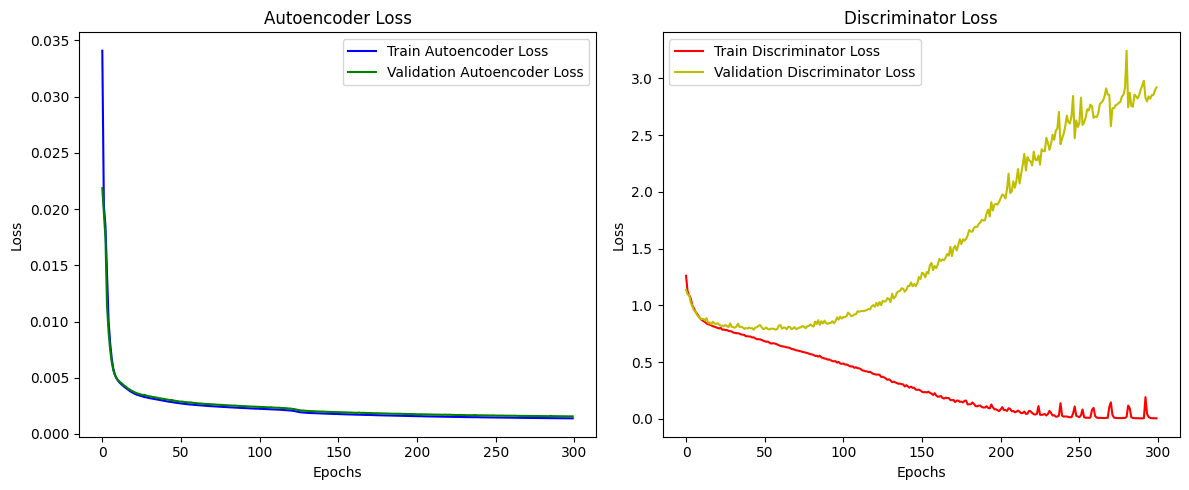

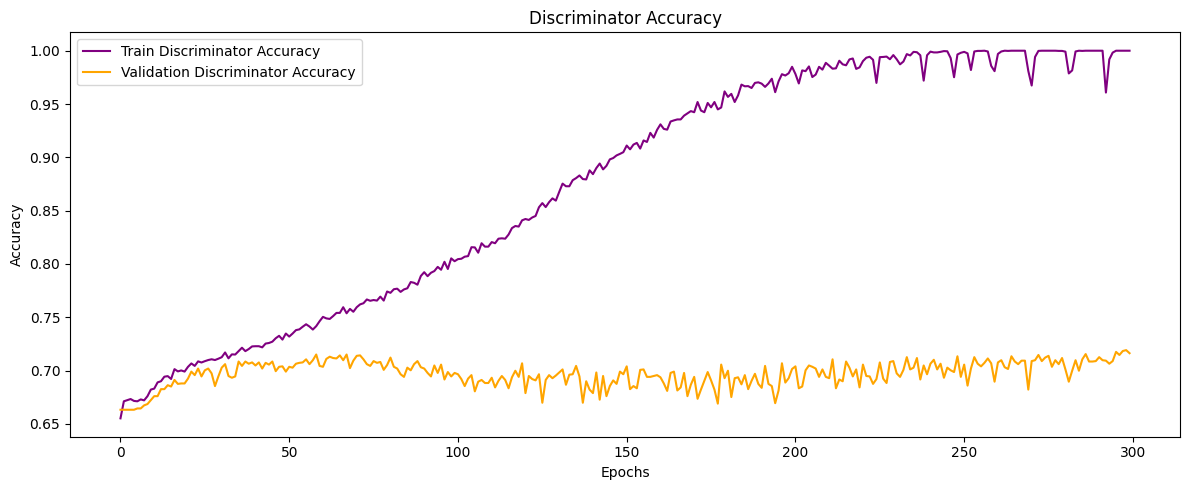

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the loss curves
def plot_loss_curves():
    plt.figure(figsize=(12, 5))

    # Autoencoder loss
    plt.subplot(1, 2, 1)
    plt.plot(autoencoder_losses_epoch, label="Train Autoencoder Loss", color="b")
    plt.plot(val_autoencoder_losses_epoch, label="Validation Autoencoder Loss", color="g")
    plt.title("Autoencoder Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Discriminator loss
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_losses_epoch, label="Train Discriminator Loss", color="r")
    plt.plot(val_discriminator_losses_epoch, label="Validation Discriminator Loss", color="y")
    plt.title("Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot discriminator accuracy
def plot_discriminator_accuracy():
    plt.figure(figsize=(12, 5))

    # Discriminator accuracy
    plt.plot(discriminator_acc_epoch, label="Train Discriminator Accuracy", color="purple")
    plt.plot(val_discriminator_acc_epoch, label="Validation Discriminator Accuracy", color="orange")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to display generated images at regular intervals
def visualize_generated_images(epoch, generated_images, save_dir="generated_images"):
    # Save generated image at the end of the epoch
    if epoch % 10 == 0:  # Adjust frequency as needed
        plt.figure(figsize=(10, 10))
        for i in range(9):  # Display 9 images in a grid
            plt.subplot(3, 3, i+1)
            plt.imshow(generated_images[i])  # Assuming images are in 3x28x28 format
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch}")
        plt.savefig(f"{save_dir}/generated_images_epoch_{epoch}.png")
        plt.show()

# Visualize loss and accuracy
plot_loss_curves()
plot_discriminator_accuracy()

In [11]:
def evaluate_discriminator(discriminator, test_data):
    test_loss_disease = 0
    test_accuracy_disease = 0
    num_batches = len(test_data)

    for batch_real, batch_label in test_data:
        # Get the output from the discriminator (only disease classification)
        disease_output = discriminator(batch_real)  # Discriminator now outputs (batch_size, num_classes)
        
        # Ensure that the output has the correct shape for comparison
        if len(disease_output.shape) == 2:
            # Check if the output is of shape (batch_size, num_classes)
            print(f"Correct shape for disease_output: {disease_output.shape}")
        else:
            # If it's not, we should reshape it
            disease_output = tf.reshape(disease_output, (batch_real.shape[0], -1))
            print(f"Reshaped disease_output to: {disease_output.shape}")

        # Compute loss for disease classification
        loss_disc_disease = loss_fn_disc(batch_label, disease_output)  # Disease classification loss
        test_loss_disease += loss_disc_disease.numpy()

        # Calculate accuracy for disease classification
        accuracy_disease = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(batch_label, disease_output))
        test_accuracy_disease += accuracy_disease.numpy()

    # Average losses and accuracy
    test_loss_disease /= num_batches
    test_accuracy_disease /= num_batches

    print(f"Test Loss (Disease): {test_loss_disease:.4f}")
    print(f"Test Accuracy (Disease): {test_accuracy_disease:.4f}")

# Evaluate the discriminator on the test data
evaluate_discriminator(discriminator, test_data)


Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: (32, 7)
Correct shape for disease_output: 